In [41]:
import xml.etree.ElementTree as ET
import tqdm
from collections import defaultdict
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
lang = 'English'
lang2lines = defaultdict(list)
langauges = ["English", "Afrikaans", "Albanian", "Amharic", "Arabic", "Bulgarian", "Cebuano", "Chinese", "Croatian",
            "Czech", "Danish", "Dutch", "Esperanto", "Farsi", "Finnish", "French", "German", "Greek", "Creole",
             "Hebrew", "Hindi", "Hungarian", "Icelandic", "Indonesian", "Italian", "Japanese", "Korean", "Latin",
             "Malagasy", "Maori", "Norwegian", "Polish", "Portuguese", "Romanian", "Russian", "Serbian", "Shona",
             "Slovak", "Spanish", "Tagalog", "Telugu", "Turkish", "Vietnamese", "Swahili-NT", "Somali", "Kabyle-NT"]

for lang in tqdm.tqdm_notebook(langauges):
    root = ET.fromstring(open("xml/" + lang + '.xml').read())
    with open("xml/" + lang + '.txt', 'w', encoding='utf-8') as out:
        for n in root.iter('seg'):
            #out.write(n.text.strip() + '\n')
            try:
                lang2lines[lang].append(n.text.strip())
            except Exception as e:
                lang2lines[lang].append("")

/home/shauli/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


In [3]:
lang2lines_clean = defaultdict(list)

In [4]:
for k in lang2lines.keys():
    print(len(lang2lines[k]))
    if len(lang2lines[k]) == 31102:
        lang2lines_clean[k] = lang2lines[k]

31102
31163
31102
30580
31102
31071
31113
31101
31102
31102
31103
29098
31102
31020
31018
31102
31102
31102
31231
31102
31089
31298
31087
31229
31292
31087
31231
31211
31099
31230
31167
31364
31102
31102
31102
31102
31029
31172
31100
31102
31102
30209
31102
7853
31102
7935


In [7]:
len(lang2lines_clean)

18

In [8]:
lang2lines_clean.keys()

dict_keys(['English', 'Albanian', 'Arabic', 'Croatian', 'Czech', 'Esperanto', 'French', 'German', 'Greek', 'Hebrew', 'Portuguese', 'Romanian', 'Russian', 'Serbian', 'Tagalog', 'Telugu', 'Vietnamese', 'Somali'])

In [9]:
lang2lines_clean["English"][2555]

"Every one that did offer an offering of silver and brass brought the LORD's offering: and every man, with whom was found shittim wood for any work of the service, brought it."

In [10]:
lang2lines_clean["Portuguese"][2555]

'Todo aquele que tinha prata ou metal para oferecer, o trazia por oferta alçada ao Senhor; e todo aquele que possuía madeira de acácia, a trazia para qualquer obra do serviço.'

In [11]:
from transformers import BertModel, BertConfig, BertTokenizer

In [12]:
import transformers

In [13]:
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-uncased")
bert = BertModel.from_pretrained("bert-base-multilingual-uncased")

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [15]:
lang2H_cls = defaultdict(list)
lang2H_mean = defaultdict(list)

sents_idx = []
bert.eval()
langs = list(lang2lines_clean.keys())

if "Spanish" in lang2lines_clean: del lang2lines_clean["Spanish"]
for i in tqdm.tqdm_notebook(range(3000)):
    j = np.random.choice(range(len(lang2lines_clean["English"])))
    sents = []
    for lang in langs:
        sents.append(lang2lines_clean[lang][j])
   
    sents_idx.append(j)
    tokens = tokenizer.batch_encode_plus(sents, padding = "longest")
    input_ids, attention_mask = tokens["input_ids"], tokens["attention_mask"]
    input_ids = torch.tensor(input_ids)
    attention_mask = torch.tensor(attention_mask)
    with torch.no_grad():
        output = bert(input_ids=input_ids, attention_mask=attention_mask)
        cls = output.last_hidden_state[:,0,:].detach().cpu().numpy()
        mean = output.last_hidden_state[:,1:-1,:].mean(dim=1).detach().cpu().numpy()
    for k, lang in enumerate(langs):
        lang2H_cls[lang].append(cls[k])
        lang2H_mean[lang].append(mean[k])

/home/shauli/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


In [16]:
import pickle
with open("reps.pickle", "wb") as f:
    pickle.dump((sents_idx, lang2H_cls, lang2H_mean), f)

In [26]:
from sklearn.metrics.pairwise import cosine_similarity

In [27]:
en = np.stack(lang2H_mean["English"])
he = np.stack(lang2H_mean["Hebrew"])
en_sents = [lang2lines_clean["English"][j] for j in sents_idx]
he_sents = [lang2lines_clean["Hebrew"][j] for j in sents_idx]

In [28]:
for i in range(100):
    print("He: {}".format(he_sents[i]))
    h = he[i]
    sims = cosine_similarity([h], en)[0]
    idx = (-sims).argsort()
    j = idx[0]
    print("En: {}".format(en_sents[j]))
    print("========================================")

He: יתר מרעהו צדיק ודרך רשעים תתעם׃
En: Howbeit from the sins of Jeroboam the son of Nebat, who made Israel to sin, Jehu departed not from after them, to wit, the golden calves that were in Bethel, and that were in Dan.
He: וישתוממו כל המון העם ויאמרו הכי זה הוא בן דוד׃
En: Speak unto Aaron, and unto his sons, and unto all the children of Israel, and say unto them; This is the thing which the LORD hath commanded, saying,
He: אשרי הגוי אשר יהוה אלהיו העם בחר לנחלה לו׃
En: And the LORD said unto Moses, Depart, and go up hence, thou and the people which thou hast brought up out of the land of Egypt, unto the land which I sware unto Abraham, to Isaac, and to Jacob, saying, Unto thy seed will I give it:
He: ויצא קין מלפני יהוה וישב בארץ נוד קדמת עדן׃
En: Howbeit from the sins of Jeroboam the son of Nebat, who made Israel to sin, Jehu departed not from after them, to wit, the golden calves that were in Bethel, and that were in Dan.
He: ויאמר האדם זאת הפעם עצם מעצמי ובשר מבשרי לזאת יקרא אשה כ

En: And Joram said, Make ready. And his chariot was made ready. And Joram king of Israel and Ahaziah king of Judah went out, each in his chariot, and they went out against Jehu, and met him in the portion of Naboth the Jezreelite.
He: והפיצותי אותך בגוים וזריתיך בארצות והתמתי טמאתך ממך׃
En: Hearken therefore unto the supplications of thy servant, and of thy people Israel, which they shall make toward this place: hear thou from thy dwelling place, even from heaven; and when thou hearest, forgive.
He: והלוים לעמת גבול הכהנים חמשה ועשרים אלף ארך ורחב עשרת אלפים כל ארך חמשה ועשרים אלף ורחב עשרת אלפים׃
En: And over against the border of the priests the Levites shall have five and twenty thousand in length, and ten thousand in breadth: all the length shall be five and twenty thousand, and the breadth ten thousand.
He: תחלת דברי פיהו סכלות ואחרית פיהו הוללות רעה׃
En: Speak unto the children of Israel, and say unto them, When ye are passed over Jordan into the land of Canaan;
He: כי תשא את ראש

En: And Joram said, Make ready. And his chariot was made ready. And Joram king of Israel and Ahaziah king of Judah went out, each in his chariot, and they went out against Jehu, and met him in the portion of Naboth the Jezreelite.
He: ולהפיל זרעם בגוים ולזרותם בארצות׃
En: Come to Bethel, and transgress; at Gilgal multiply transgression; and bring your sacrifices every morning, and your tithes after three years:
He: ואספו אספה אסיר על בור וסגרו על מסגר ומרב ימים יפקדו׃
En: And Joram said, Make ready. And his chariot was made ready. And Joram king of Israel and Ahaziah king of Judah went out, each in his chariot, and they went out against Jehu, and met him in the portion of Naboth the Jezreelite.
He: ואם חי יהוה יאמרו לכן לשקר ישבעו׃
En: Then said Zedekiah unto Jeremiah, Let no man know of these words, and thou shalt not die.
He: ודוד בן איש אפרתי הזה מבית לחם יהודה ושמו ישי ולו שמנה בנים והאיש בימי שאול זקן בא באנשים׃
En: Now David was the son of that Ephrathite of Bethlehemjudah, whose

In [37]:
lang2H = {k:np.stack(v) for k,v in lang2H_mean.items()}

In [38]:
sims = defaultdict(dict)
sims_np = np.zeros((len(lang2H), len(lang2H)))

for i, lang in enumerate(lang2H.keys()):
    for j, lang2 in enumerate(lang2H.keys()):
        
        h_lang1 = lang2H[lang]
        h_lang2 = lang2H[lang2]
        h_lang1 /= np.linalg.norm(h_lang1, axis = 1, keepdims = True)
        h_lang2 /= np.linalg.norm(h_lang2, axis = 1, keepdims = True)
        
        #sim =  cosine_similarity(lang2H_mean[lang], lang2H_mean[lang2]).mean()
        sim = ((h_lang1*h_lang2).sum(axis=1)).mean()
        sims[lang][lang2] = sim
        sims_np[i][j] = sim

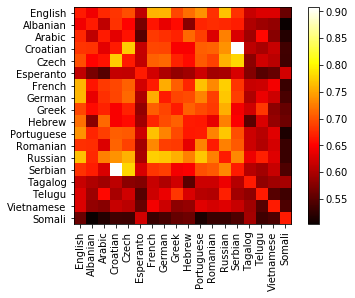

In [39]:
langs = list(lang2H.keys())
np.fill_diagonal(sims_np, np.mean(sims_np))
plt.imshow(sims_np, cmap='hot', interpolation='nearest')
plt.xticks(range(len(langs)), langs, rotation=90)
plt.yticks(range(len(langs)), langs)
plt.colorbar()
plt.show()

In [40]:
sims_np.reshape(-1)

array([0.66662472, 0.6434828 , 0.67470998, 0.68196857, 0.69867951,
       0.61289859, 0.76054376, 0.76228005, 0.69391501, 0.71728766,
       0.73909426, 0.67841464, 0.76749623, 0.68010741, 0.61672056,
       0.63022959, 0.63075966, 0.56035703, 0.6434828 , 0.66662472,
       0.61225677, 0.68145066, 0.65228921, 0.57014108, 0.66259223,
       0.63722491, 0.65638167, 0.57897574, 0.67238206, 0.6782974 ,
       0.67510945, 0.66742903, 0.60317701, 0.59261125, 0.58627093,
       0.50243747, 0.67470998, 0.61225677, 0.66662472, 0.63485336,
       0.66153759, 0.54880559, 0.68591064, 0.67946649, 0.671893  ,
       0.71478534, 0.68896997, 0.62959182, 0.7282033 , 0.62780201,
       0.59367228, 0.65534139, 0.5798524 , 0.51891929, 0.68196857,
       0.68145066, 0.63485336, 0.66662472, 0.77505696, 0.61518008,
       0.69352841, 0.69246739, 0.64719421, 0.64720744, 0.70787644,
       0.71125376, 0.73966116, 0.90829349, 0.61152279, 0.59899551,
       0.61705554, 0.53704584, 0.69867951, 0.65228921, 0.66153

In [192]:
help(np.fill_diagonal)

Help on function fill_diagonal in module numpy:

fill_diagonal(a, val, wrap=False)
    Fill the main diagonal of the given array of any dimensionality.
    
    For an array `a` with ``a.ndim >= 2``, the diagonal is the list of
    locations with indices ``a[i, ..., i]`` all identical. This function
    modifies the input array in-place, it does not return a value.
    
    Parameters
    ----------
    a : array, at least 2-D.
      Array whose diagonal is to be filled, it gets modified in-place.
    
    val : scalar
      Value to be written on the diagonal, its type must be compatible with
      that of the array a.
    
    wrap : bool
      For tall matrices in NumPy version up to 1.6.2, the
      diagonal "wrapped" after N columns. You can have this behavior
      with this option. This affects only tall matrices.
    
    See also
    --------
    diag_indices, diag_indices_from
    
    Notes
    -----
    .. versionadded:: 1.4.0
    
    This functionality can be obtained via